In [1]:

import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.interpolate import griddata
import torch.nn.functional as F
import torch.distributions as D
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)



pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


cuda:0


In [2]:
global temp_list
temp_list = []
Agent_number_n=6;
Alpha = 1.0;

echo = 1001
BATCH_SIZE = 64
LR = 0.001           # learning rate for generator
devided_number = 1

uniformlow = 0
uniformhigh = 1.0

normalloc = 0.5
normalscale = 0.1

doublePeakHighMean = 0.9
doublePeakLowMean = 0.1
doublePeakStd = 0.04

beta_a = 0.3
beta_b = 0.2

def Generate_distribution(Agent_number_n):
    #return sorted(np.random.rand(Agent_number_n), reverse=True)
    return sorted(np.random.normal(normalloc,normalscale,Agent_number_n), reverse=True)
Prior_Distribution = "normal"

In [3]:
new_input = 3
def Dimensionality_reduction(data_sorted):
    out_data = torch.ones(new_input).cuda()
    out_data[0] = torch.max(data_sorted) 
    out_data[1] = torch.sum(data_sorted) 
    
    temp_list = []
    for i in range(len(data_sorted)-1):
        temp_list.append(data_sorted[i] - data_sorted[i + 1])
    
    temp_tensor = torch.stack(temp_list)    
    out_data[2] = torch.max(temp_tensor) 
    return out_data


In [4]:
d_1 = D.uniform.Uniform(uniformlow, uniformhigh)
distributionRatio_1 = d_1.cdf(1) - d_1.cdf(0)
distributionBase_1 = d_1.cdf(0)

d_2 = D.normal.Normal(normalloc, normalscale)
distributionRatio_2 = d_2.cdf(1) - d_2.cdf(0)
distributionBase_2 = d_2.cdf(0)

d_3 = D.normal.Normal(doublePeakLowMean, doublePeakStd)
d_4 = D.normal.Normal(doublePeakHighMean, doublePeakStd)
distributionRatio_3 = (d_3.cdf(1) + d_4.cdf(1) - d_3.cdf(0) - d_4.cdf(0)) / 2
distributionBase_3 = d_3.cdf(0) + d_4.cdf(0)

# d_5 = D.beta.Beta(beta_a,beta_b)

# d10 = D.beta.Beta(0.5,0.5)


def cdf(x, y, i=None):
    if (y == "uniform"):
        return (d_1.cdf(x) - distributionBase_1) / distributionRatio_1
    elif (y == "normal"):
        return (d_2.cdf(x) - distributionBase_2) / distributionRatio_2
    elif (y == "twopeak"):
        return (d_3.cdf(x) + d_4.cdf(x) -
                distributionBase_3) / 2 / distributionRatio_3


def pdf(x, y, i=None):
    x= x.cpu().type(torch.float32)
    if (y == "uniform"):
        return torch.pow(torch.tensor(10.0), d_1.log_prob(x)).to(dev)
    elif (y == "normal"):
        return torch.pow(torch.tensor(10.0), d_2.log_prob(x)).to(dev)
    elif (y == "twopeak"):
        return (torch.pow(torch.tensor(10.0), d_3.log_prob(x)) +
                torch.pow(torch.tensor(10.0), d_4.log_prob(x))).to(dev) / 2 
    
def Generate_distribution(Agent_number_n):
    return np.random.rand(Agent_number_n)
    #return np.random.normal(normalloc,normalscale,Agent_number_n)


In [5]:
print(torch.tensor(10.0).to(dev))
print(pdf(torch.ones(1)*0.2,"uniform"))
print(pdf(torch.ones(1)*0.2,"normal"))


tensor(10., device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.0008], device='cuda:0')


In [6]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function_label(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h

def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    h_list = []
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
        
        h = h_function_label(temp)
        h_list.append(float(h))
    temp_list = np.array(temp_list)
    x_list = np.array(x_list)
    return temp_list,S,x_list,h_list
    

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    temp_list = np.array(temp_list)
    return temp_list,S
    

def read_testing_data():
    for i in range(10000):
        appen_test(Generate_distribution(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(testing_data)
print(testing_label)

[[[0.57540204 0.71846366 0.00216551 0.79314785 0.4143874 ]
  [0.28567917 0.71846366 0.00216551 0.79314785 0.4143874 ]
  [0.28567917 0.57540204 0.00216551 0.79314785 0.4143874 ]
  [0.28567917 0.57540204 0.71846366 0.79314785 0.4143874 ]
  [0.28567917 0.57540204 0.71846366 0.00216551 0.4143874 ]
  [0.28567917 0.57540204 0.71846366 0.00216551 0.79314785]]

 [[0.85609549 0.60980555 0.38665985 0.25387938 0.43369242]
  [0.82369746 0.60980555 0.38665985 0.25387938 0.43369242]
  [0.82369746 0.85609549 0.38665985 0.25387938 0.43369242]
  [0.82369746 0.85609549 0.60980555 0.25387938 0.43369242]
  [0.82369746 0.85609549 0.60980555 0.38665985 0.43369242]
  [0.82369746 0.85609549 0.60980555 0.38665985 0.25387938]]

 [[0.17094025 0.36466157 0.9617503  0.90878519 0.88159999]
  [0.8344531  0.36466157 0.9617503  0.90878519 0.88159999]
  [0.8344531  0.17094025 0.9617503  0.90878519 0.88159999]
  [0.8344531  0.17094025 0.36466157 0.90878519 0.88159999]
  [0.8344531  0.17094025 0.36466157 0.9617503  0.881

In [7]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h
                
                
x_list = []
y_list = []
z_list = []
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        x_list.append(testing_data[index][i][0])
        y_list.append(testing_data[index][i][1])
        h = h_function(testing_data[index][i])
        z_list.append(float(h))
        h_list.append(float(h))
    result_list.append(sum(h_list)/testing_label[index]) 
    
    
print(max(result_list), min(result_list), max(result_list)-min(result_list),sum(result_list)/len(result_list))

5.366723445749804 4.999999999999998 0.3667234457498054 5.025170399975017


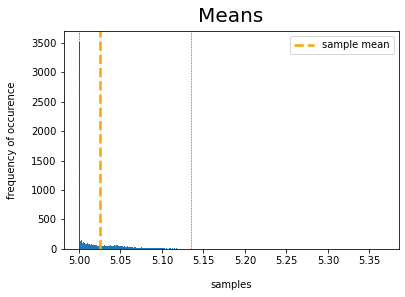

In [8]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [9]:
tensor_sample_list,indices = torch.sort(torch.rand(devided_number,requires_grad=True).to(dev))  # random ideas\n
print(tensor_sample_list)

tensor([0.8560], device='cuda:0', grad_fn=<SortBackward>)


In [10]:
print(cdf(tensor_sample_list,Prior_Distribution))
print(cdf(tensor_sample_list,"normal"))

tensor([0.9998], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9998], device='cuda:0', grad_fn=<DivBackward0>)


In [11]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)



def redistribution_value_function(input_tensor):
    S = torch.max(torch.sum(input_tensor), torch.ones(1).to(dev))
    temp_list = []

    for i in range(Agent_number_n):
        temp = []

        for j in range(Agent_number_n):
            if(i != j):
                temp .append(input_tensor[j])

        temp = torch.stack(temp)
        temp_list.append(temp)
    return torch.stack(temp_list), S


class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        self.input_dim = new_input#(Agent_number_n-1)
        self.hidden_dim = 128
        self.output_dim = 1
        self.hidden_layer_count = 6

        current_dim = self.input_dim
        self.layers = torch.nn.ModuleList()
        for i in range(self.hidden_layer_count):
            self.layers.append(torch.nn.Linear(current_dim, self.hidden_dim))
            current_dim = self.hidden_dim
        self.layers.append(torch.nn.Linear(current_dim, self.output_dim))

    def calculate(self, value_list):
        h = Dimensionality_reduction(value_list)
        for layer in self.layers:
            h = torch.relu(layer(h))
        return h

    def forward(self, input_list, input_label, input_data):
        global iteration, echo, target_order
        loss1 = 0
        loss2 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)

        input_data = torch.from_numpy(
            np.array(input_data)).to(dev).type(torch.float32)
        
        input_label = torch.from_numpy(
            np.array(input_label)).to(dev).type(torch.float32)
        
        
        random_index = random.randint(0, Agent_number_n-1)
        tensor_sample_list,indices = torch.sort(torch.rand(devided_number,requires_grad=True).to(dev))
     
        tensor_sample = torch.rand(devided_number,requires_grad=True)[0].to(dev)
    
        input_data_temp = input_data.detach().clone()
        
        input_data_temp[random_index] = tensor_sample

        value_list_tensor, S_tensor = redistribution_value_function(
            input_data_temp)
       
        h_list = []
        for i in range(Agent_number_n):
            h = self.calculate(
                value_list_tensor[i].to(dev).type(torch.float32))
            h_list.append(h)
            
        S_tensor = S_tensor.detach().to(dev).type(torch.float32)
        
        sum_h = torch.sum(torch.cat(h_list)).to(dev)
        
        temp_loss1 = torch.where((Agent_number_n-1)*S_tensor > sum_h,
                 torch.square(((Agent_number_n-1)*S_tensor - sum_h)),
                 torch.zeros(1).to(dev)
              )

        temp_loss2 = torch.where((Agent_number_n-Alpha)*S_tensor < sum_h,
                    torch.square((sum_h-(Agent_number_n-Alpha)*S_tensor))/10000,
                    torch.zeros(1).to(dev)
                  )


        loss1 = temp_loss1 * pdf(tensor_sample, Prior_Distribution)
        loss2 = temp_loss2 * pdf(tensor_sample, Prior_Distribution)
                
        return loss1, loss2
    
    def supervised_loss(self, input_list,label):
        global iteration,echo,target_order
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)
        loss = 0 
        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            loss += torch.square(h - label[i])
        return loss

In [12]:
random.seed(200)
torch.manual_seed(256)
net  = Net()
net.apply(weight_init)
#net = torch.load("save/Deep_learning_F_normal_10_1")
net.to(dev)

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.00005)
optimizer = opt.Adam(net.parameters(), lr=LR)
#optimizer = opt.Adadelta(net.parameters(), lr=1.0)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.98)
index_train_list = []
index_test_list = []
train_losses = []
test_losses = []

In [13]:
#supervised
index_supervisedtrain_list = []
supervisedtrain_losses = []
for iteration in range(1000):

    temp_number = 0
    total_batch_loss = 0 
    
    loss_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_S, training_data,label = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss = net.supervised_loss(training_data_i, label)
        denominator += 1
        loss_sum += h_loss

    loss_sum = torch.sum(loss_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss += float(loss_sum)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (iteration%50 == 0):
        print(iteration,loss,total_batch_loss)
        index_supervisedtrain_list.append(iteration)
        supervisedtrain_losses.append(total_batch_loss)
    scheduler.step()

0 tensor(43.9148, device='cuda:0', grad_fn=<DivBackward0>) 2810.544189453125
50 tensor(0.0666, device='cuda:0', grad_fn=<DivBackward0>) 4.263567924499512
100 tensor(0.0219, device='cuda:0', grad_fn=<DivBackward0>) 1.4002183675765991
150 tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>) 0.44540563225746155
200 tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) 0.10128256678581238
250 tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>) 0.1963392049074173
300 tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) 0.06906314939260483
350 tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>) 0.03819606080651283
400 tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 0.04611534997820854
450 tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>) 0.033150624483823776
500 tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 0.012169127352535725
550 tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 0.010482745245099068
600 tensor(0.0002, device='cuda:0', grad_fn=<

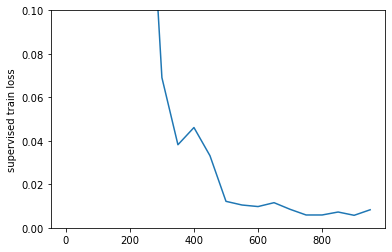

In [14]:
plt.ylim(0, 0.1)
plt.plot(index_supervisedtrain_list ,supervisedtrain_losses)
plt.ylabel('supervised train loss')

plt.show()

In [15]:
optimizer = opt.Adam(net.parameters(), lr=LR/100)
#optimizer = opt.Adadelta(net.parameters(), lr=1.0)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.98)

In [16]:
for iteration in range(int(echo)):
    
    temp_number = 0
    total_batch_loss = 0 
        
    loss2_list = []
    loss1_sum = 0
    loss2_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_label, training_data,label = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss1, h_loss2 = net(training_data_i, training_label,
                                       training_data)
        denominator += 1
        loss1_sum += h_loss1
        loss2_sum += h_loss2

    loss_sum = torch.sum(loss1_sum + loss2_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss +=float(loss_sum)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    temp_number = iteration
    index_train_list.append(iteration)
    train_losses.append(total_batch_loss)
    if (iteration%50 == 0):
        print(temp_number, loss, float(loss1_sum), float(loss2_sum))

        print("batch iteration", iteration)
        print("batch_loss: %.4f " % total_batch_loss)

        result_list = []
        for index in range(len(testing_data)):
            h_list = []
            for i in range(Agent_number_n):
                h = net.calculate(
                    torch.tensor(testing_data[index][i]).to(dev).type(
                        torch.float32))
                h_list.append(float(h))
            result_list.append(sum(h_list) / testing_label[index])
        print(max(result_list), min(result_list),
              max(result_list) - min(result_list),
              (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )

        index_test_list.append(iteration)
        test_losses.append(
            (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )
        print()
        
    scheduler.step()


0 tensor(3.0378e-06, device='cuda:0', grad_fn=<DivBackward0>) 4.062559128215071e-06 0.00019035952573176473
batch iteration 0
batch_loss: 0.0002 
5.382400856839455 4.983886395365483 0.3985144614739724 0.04803011416925518

50 tensor(2.2452e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.001436903839930892
batch iteration 50
batch_loss: 0.0014 
5.4118259469879755 5.038883686065674 0.37294226092230165 0.04119281832082944

100 tensor(1.7185e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0010998602956533432
batch iteration 100
batch_loss: 0.0011 
5.37522330502957 5.004783749580383 0.3704395554491864 0.06741877247496575

150 tensor(1.6390e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0010489282431080937
batch iteration 150
batch_loss: 0.0010 
5.347624524866512 4.987510025501251 0.3601144993652605 0.08901268133600126

200 tensor(1.1170e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0007148878648877144
batch iteration 200
batch_loss: 0.0007 
5.324716591472094 4.9765469431877

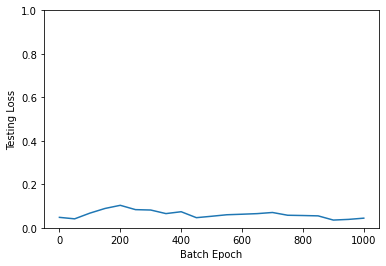

FileNotFoundError: [Errno 2] No such file or directory: 'save/test_loss_unfeed_normal_10.csv'

In [17]:
plt.ylim(0, 1.0)
plt.plot(index_test_list,test_losses)
plt.ylabel('Testing Loss')
plt.xlabel('Batch Epoch')
plt.show()

import csv
with open('save/test_loss_feed_normal_10.csv', 'w', newline='') as csvfile_feed:
    spamwriter = csv.writer(csvfile_feed)
    spamwriter.writerow(index_test_list)
    spamwriter.writerow(test_losses)


with open('save/test_loss_unfeed_normal_10.csv') as csvfile_unfeed:
    reader = csv.reader(csvfile_unfeed)
    list_feed = []
    for row in reader:
        row = np.array(row)
        temp_list = []
        for i in range(len(row)):
            temp_list.append(float(row[i]))

        list_feed.append(temp_list)
    plt.ylim(0, 1.0)
    plt.plot(list_feed[0],list_feed[1],label='neural network')
    plt.plot(index_test_list,test_losses,label='feed distribution')
    plt.ylabel('Testing Loss')
    plt.xlabel('Batch Epoch')
    #plt.title('Two or more lines on same plot with suitable legends ')
    # show a legend on the plot
    plt.legend()
    plt.show()


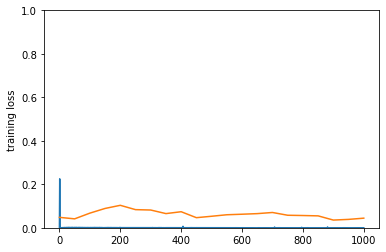

In [18]:
plt.ylim(0, 1.0)

plt.plot(index_train_list,train_losses)
plt.ylabel('training loss')

plt.plot(index_test_list,test_losses)
plt.ylabel('training loss')

plt.show()

In [19]:
torch.save(net, "save/Deep_learning_F_normal_6_1")

In [20]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = net.calculate(torch.tensor(testing_data[index][i]).cuda().type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list),sum(result_list)/len(result_list)-min(result_list))

5.388471929843449 4.9892798009724215 0.39919212887102784 0.03358355703784177


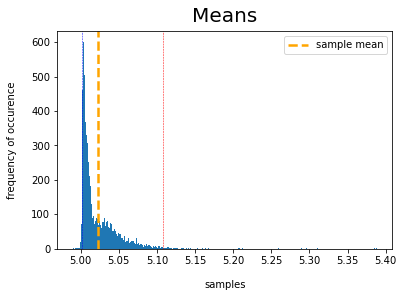

In [21]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()